# Inter-annotator agreement between the first 10 annotators of WS-353
Measured in Kappa and Rho:
 - against the gold standard which is the mean of all annotators, as described in Hill et al 2014 (footnote 6)
 - against each other
 
 Using Kohen's kappa, which is binary, so I average across pairs of annotators.

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from skll.metrics import kappa
from scipy.stats import spearmanr
from itertools import combinations

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
columns = 'Word 1,Word 2,Human (mean),1,2,3,4,5,6,7,8,9,10,11,12,13'.split(',')
df1 = pd.read_csv('../thesisgenerator/similarity-data/wordsim353/set1.csv')[columns]
df2 = pd.read_csv('../thesisgenerator/similarity-data/wordsim353/set2.csv')[columns]
df = pd.concat([df1, df2], ignore_index=True)
df_gold = pd.read_csv('../thesisgenerator/similarity-data/wordsim353/combined.csv',
                     names='w1 w2 sim'.split())

In [3]:
# had to remove trailing space from their files to make it parse with pandas
marco = pd.read_csv('../thesisgenerator/similarity-data/MEN/agreement/marcos-men-ratings.txt',
                   sep='\t', index_col=[0,1], names=['w1', 'w2', 'sim']).sort_index().convert_objects(convert_numeric=True)
elia = pd.read_csv('../thesisgenerator/similarity-data/MEN/agreement/elias-men-ratings.txt',
                   sep='\t', index_col=[0,1], names=['w1', 'w2', 'sim']).sort_index().convert_objects(convert_numeric=True)

In [4]:
df.head()

,Word 1,Word 2,Human (mean),1,2,3,4,5,6,7,8,9,10,11,12,13
0,love,sex,6.77,9,6,8,8,7,8,8.0,4,7,2,6,7,8
1,tiger,cat,7.35,9,7,8,7,8,9,8.5,5,6,9,7,5,7
2,tiger,tiger,10.00,10,10,10,10,10,10,10.0,10,10,10,10,10,10
3,book,paper,7.46,8,8,7,7,8,9,7.0,6,7,8,9,4,9
4,computer,keyboard,7.62,8,7,9,9,8,8,7.0,7,6,8,10,3,9


In [5]:
# Each index ``i`` returned is such that ``bins[i-1] <= x < bins[i]``
def bin(arr, nbins=2, debug=False):
    bins = np.linspace(arr.min(), arr.max(), nbins+1)
    if debug:
        print('bins are', bins)
    return np.digitize(arr, bins[1:-1])

In [6]:
bin(df['1'], nbins=5, debug=True)[:10]

bins are [  1.    2.8   4.6   6.4   8.2  10. ]


array([4, 4, 4, 3, 3, 3, 2, 3, 3, 3])

In [7]:
bin(np.array([0, 2.1, 5.8, 7.9, 10]), debug=True) # 0 and 10 are needed to define the range of values

bins are [  0.   5.  10.]


array([0, 0, 1, 1, 1])

In [8]:
bin(np.array([0, 2.1, 5.8, 7.9, 10]), nbins=3, debug=True)

bins are [  0.           3.33333333   6.66666667  10.        ]


array([0, 0, 1, 2, 2])

In [9]:
df.describe()

,Human (mean),1,2,3,4,5,6,7,8,9,10,11,12,13
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,5.855864,6.902266,5.867422,6.592068,5.456091,5.671388,6.274788,5.233711,5.980170,5.129178,5.774788,5.637394,5.524079,6.076487
std,2.175478,2.049028,3.048985,2.963681,3.145871,2.094284,2.279071,3.024976,2.711959,2.565632,3.062950,2.698951,2.755184,3.071559
min,0.230000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.380000,6.000000,4.000000,5.000000,2.000000,4.000000,5.000000,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000,3.000000
50%,6.310000,7.000000,7.000000,8.000000,6.000000,5.000000,7.000000,6.000000,7.000000,6.000000,6.000000,6.000000,6.000000,7.000000
75%,7.560000,8.000000,8.000000,9.000000,8.000000,7.000000,8.000000,8.000000,8.000000,7.000000,8.000000,8.000000,8.000000,8.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [10]:
elia.describe()

,sim
count,3000.000000
mean,3.564333
std,2.015907
min,1.000000
25%,1.000000
50%,4.000000
75%,6.000000
max,7.000000


# WS353: Kappa against each other/ against mean 

In [11]:
bin_counts = range(2, 6)
# pair, bin count, kappa
kappas_pair = []
for name1, name2 in combinations(range(1,14), 2):
    for b in bin_counts:
        kappas_pair.append(['%d-%d'%(name1, name2), 
                       b, 
                       kappa(bin(df[str(name1)], b), bin(df[str(name2)], b))])

kappas_mean = []
for name in range(1, 14):
    for b in bin_counts:
        kappas_mean.append(['%d-m'%name, 
                       b, 
                       kappa(bin(df[str(name)], b), bin(df_gold.sim, b))])

kappas_men = [] # MEN data set- marco vs elia
for b in bin_counts:
    kappas_men.append(['marco-elia',
                       b,
                       kappa(bin(marco.sim.values, b), bin(elia.sim.values, b))])

In [12]:
kappas1 = pd.DataFrame(kappas_pair, columns=['pair', 'bins', 'kappa'])
kappas1['kind'] = 'WS353-pairwise'
kappas2 = pd.DataFrame(kappas_mean, columns=['pair', 'bins', 'kappa'])
kappas2['kind'] = 'WS353-to mean'
kappas3 = pd.DataFrame(kappas_men, columns=['pair', 'bins', 'kappa'])
kappas3['kind'] = 'MEN'
kappas = pd.concat([kappas1, kappas2, kappas3], ignore_index=True)
kappas.head(3)

,pair,bins,kappa,kind
0,1-2,2,0.508072,WS353-pairwise
1,1-2,3,0.342261,WS353-pairwise
2,1-2,4,0.261647,WS353-pairwise


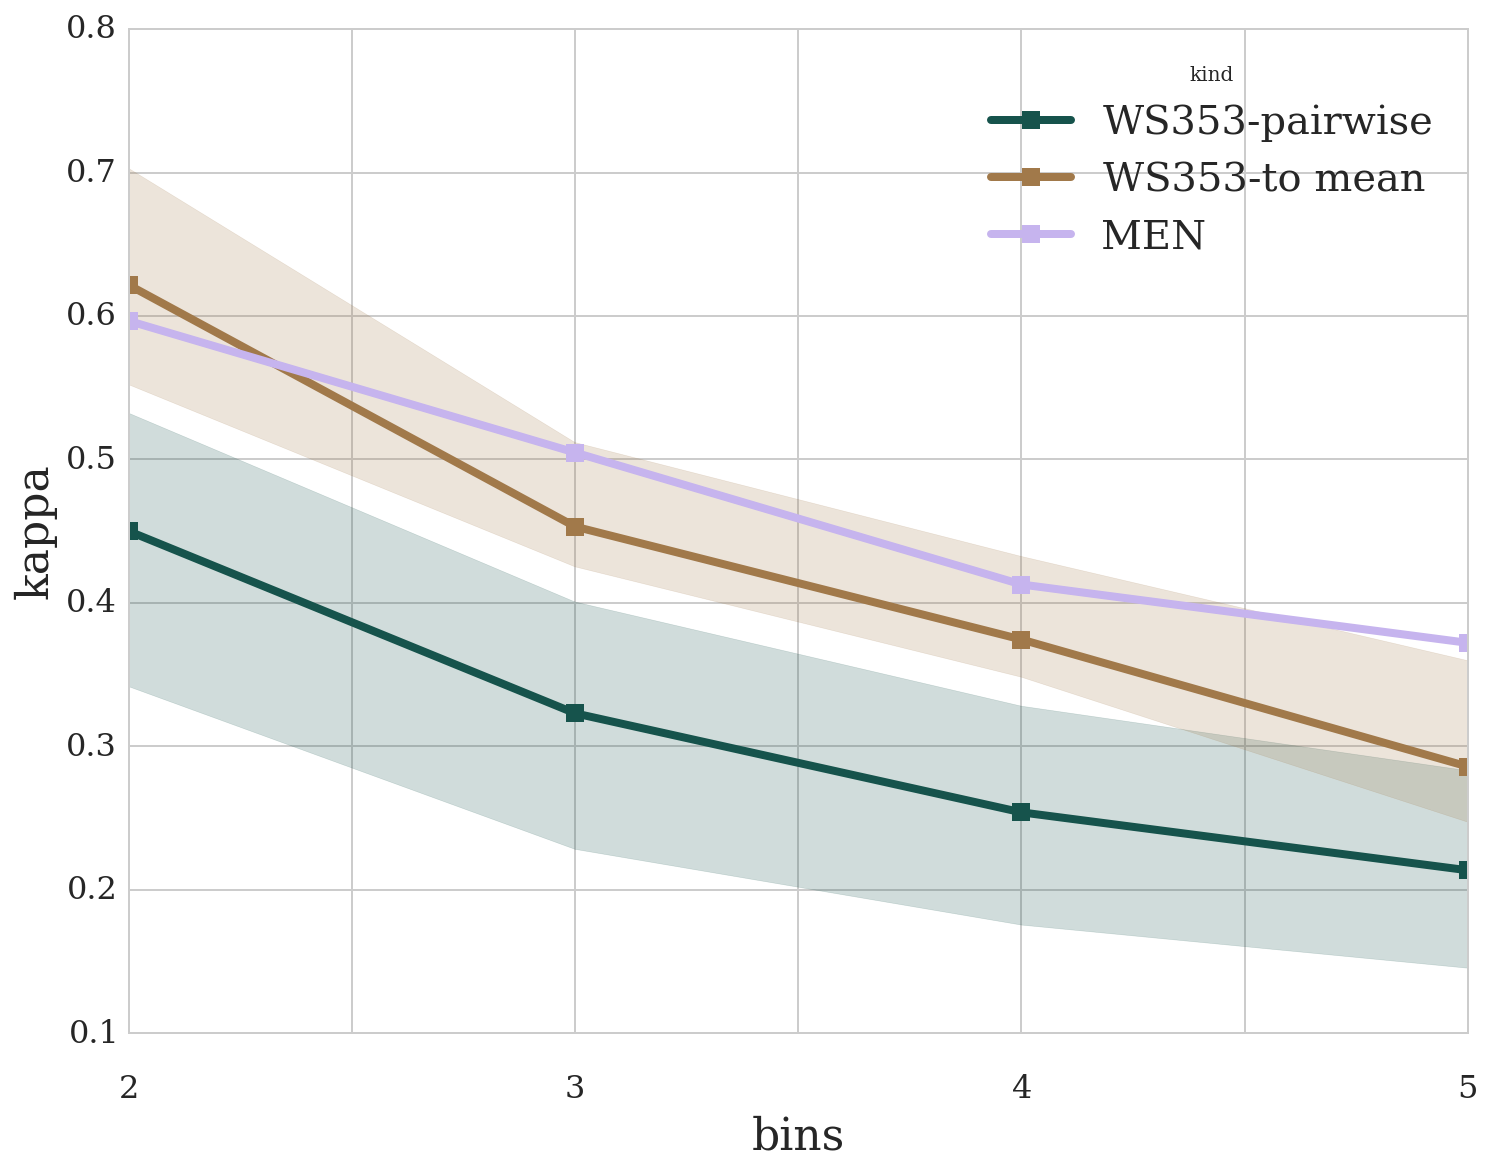

In [13]:
with sns.color_palette("cubehelix", 3):
    ax = sns.tsplot(kappas, time='bins', unit='pair', condition='kind', value='kappa', 
               marker='s', linewidth=4);
ax.set_xticklabels(np.arange(kappas.bins.min(), kappas.bins.max() + 0.01, 0.5).astype(np.int))
sparsify_axis_labels(ax)
plt.savefig('plot-intrinsic-ws353-kappas.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

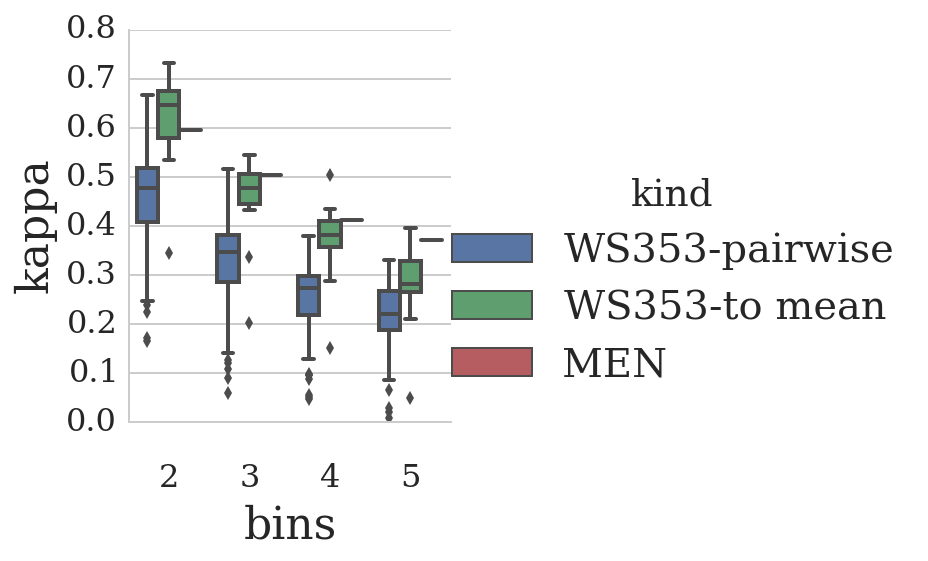

In [14]:
# sns.tsplot(kappas, time='bins', unit='pair', condition='kind', value='kappa', 
sns.factorplot(data=kappas, x='bins', y='kappa', hue='kind', kind='box')

In [15]:
kappas.groupby(['bins', 'kind']).mean()

kappa
bins kind                    
2    MEN             0.596591
     WS353-pairwise  0.450057
     WS353-to mean   0.621625
3    MEN             0.504816
     WS353-pairwise  0.323088
     WS353-to mean   0.453216
4    MEN             0.412873
     WS353-pairwise  0.254069
     WS353-to mean   0.374521
5    MEN             0.372213
     WS353-pairwise  0.213695
     WS353-to mean   0.285952

In [16]:
rhos_pair = []
for name1, name2 in combinations(range(1,14), 2):
    rhos_pair.append(spearmanr(bin(df[str(name1)], b), bin(df[str(name2)], b))[0])
    
rhos_mean = []
for name in range(1,14):
    rhos_mean.append(spearmanr(bin(df[str(name)], b), bin(df_gold.sim, b))[0])

0.565874935874 0.73582286453


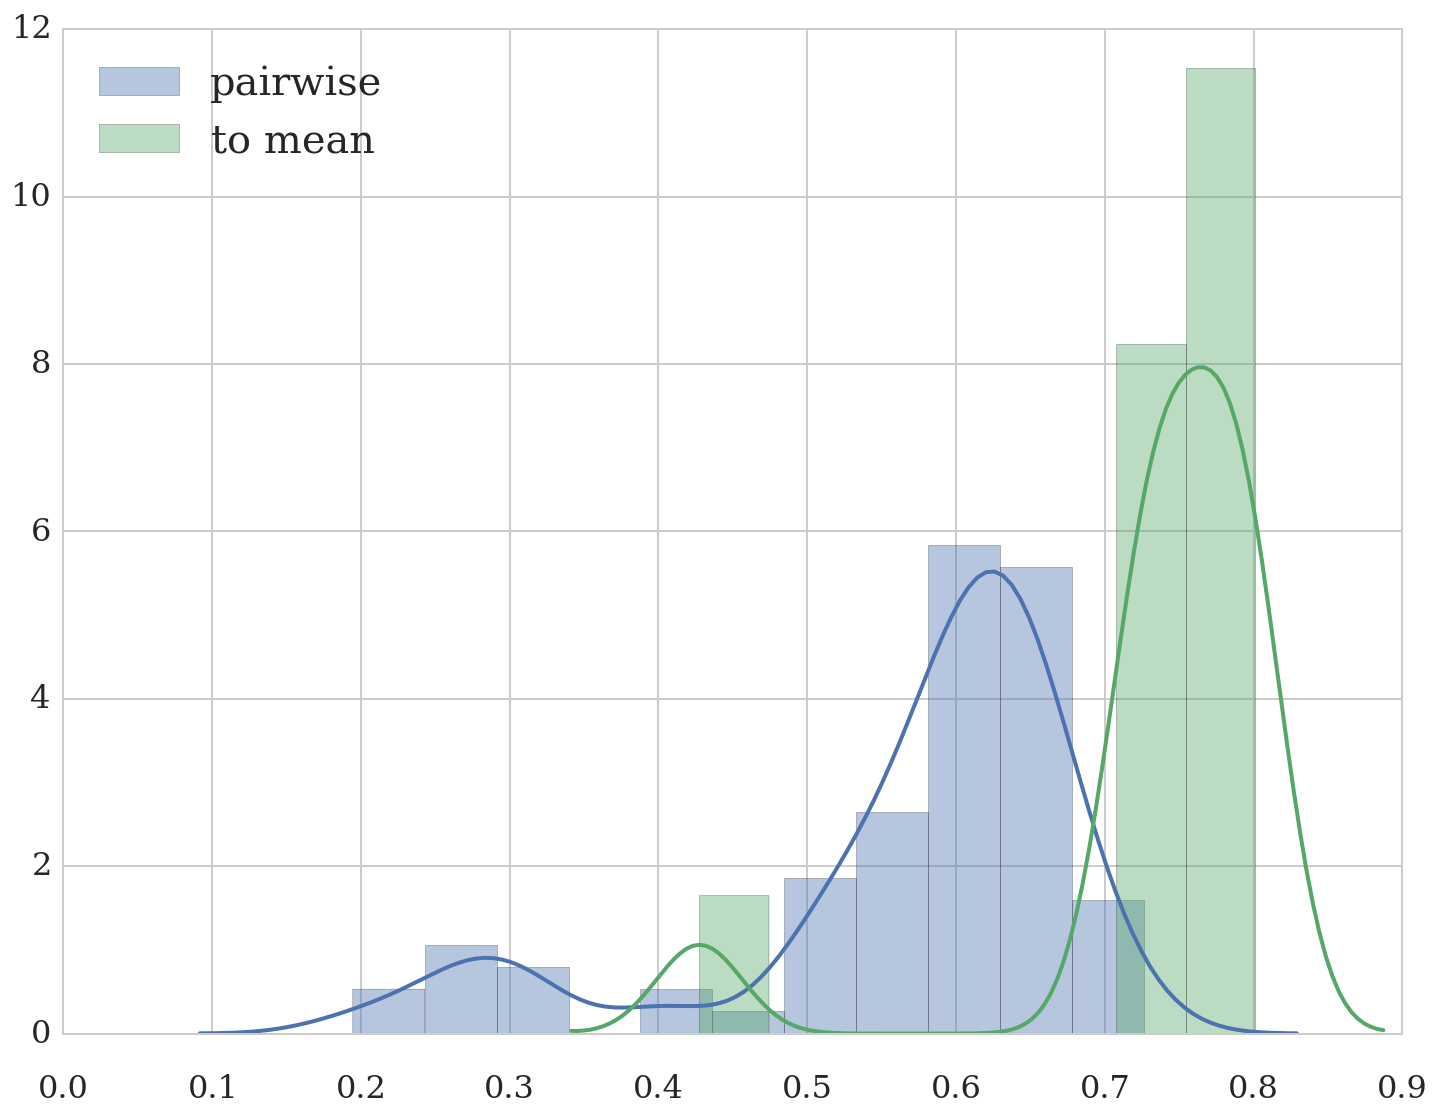

In [17]:
sns.distplot(rhos_pair, label='pairwise');
# plt.axvline(np.mean(rhos_pair));

sns.distplot(rhos_mean, label='to mean');
# plt.axvline(np.mean(rhos_mean), color='g');
plt.legend(loc='upper left');
plt.savefig('plot-intrinsic-ws353-rhos.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
print(np.mean(rhos_pair), np.mean(rhos_mean))

In [18]:
# Fisher transform: http://stats.stackexchange.com/a/19825 and wiki article therein
np.tanh(np.arctanh(rhos_pair).mean()), np.tanh(np.arctanh(rhos_mean).mean())

(0.57579912599161975, 0.7449841374506041)

In [19]:
from nltk.metrics.agreement import AnnotationTask

In [20]:
AnnotationTask(data=[
        ('coder1', 'obj1', 'label1'), 
        ('coder1', 'obj2', 'label2'), 
        ('coder2', 'obj1', 'label1'),
        ('coder2', 'obj2', 'label2'),
        ('coder3', 'obj1', 'label1'),
        ('coder3', 'obj2', 'label1'),
    ]).multi_kappa()

0.33333333333333326

In [21]:
multikappas = []
for name in range(1, 14):
    for b in bin_counts:
        labels = bin(df[str(name)], b) 
#         gold_labels = bin(df_gold.sim, b)
        for i, label in enumerate(labels):
            multikappas.append(('coder%d'%name, 'wordpair%d'%i, label))

In [22]:
AnnotationTask(multikappas).multi_kappa()
# WTF nltk, you are great

1.0865600389551853

# The same thing for the MEN dataset
Annotations by Marco and Elia

In [23]:
spearmanr(marco.sim, elia.sim) # they report .6845

(0.68458381557442416, 0.0)